In [1]:
import sys
sys.path.insert(0,'/home/dlr16/Applications/anaconda2/envs/PyDenseCRF/lib/python2.7/site-packages')

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

## Start from scratch

In [3]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[0:512, 0:512]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([256, 256], 128*128)

In [4]:
probs = rv.pdf(pos)
probs = (probs-probs.min()) / (probs.max()-probs.min())
probs = 0.2 * (probs-0.5) + 0.5
probs = np.tile(probs[:,:,np.newaxis],(1,1,2))
probs[:,:,1] = 1 - probs[:,:,0]

# permute for graph
probs = np.transpose(probs,(2,0,1))

(-0.5, 511.5, 511.5, -0.5)

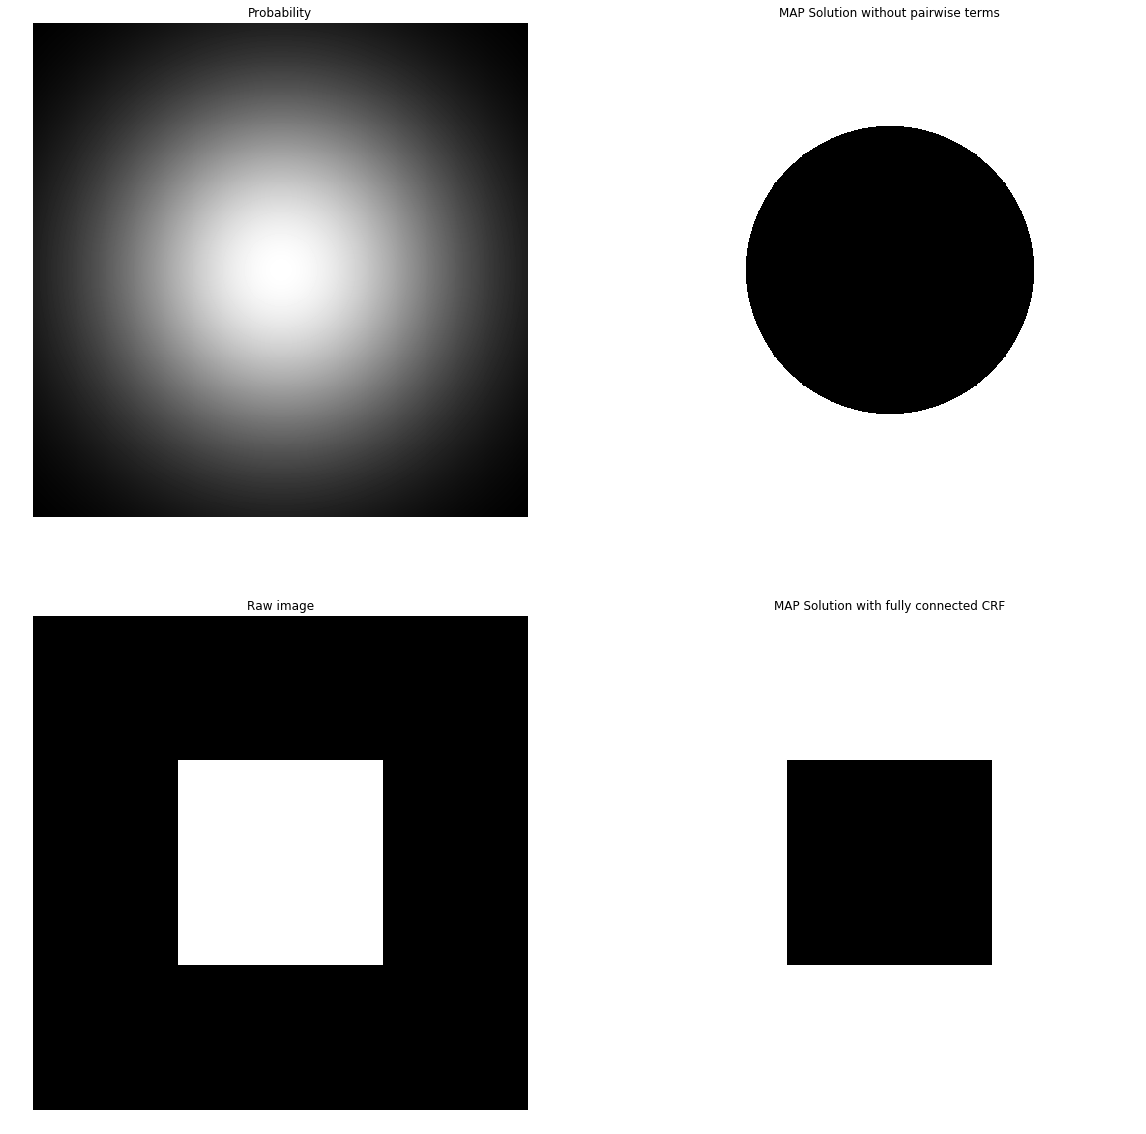

In [5]:
nchannels=1

# Inference without pair-wise terms
U = unary_from_softmax(probs) # note: num classes is first dim
d = dcrf.DenseCRF2D(probs.shape[1],probs.shape[2],probs.shape[0])
d.setUnaryEnergy(U)

Q_Unary = d.inference(10)
map_soln_Unary = np.argmax(Q_Unary, axis=0).reshape((probs.shape[1],probs.shape[2]))


# Create simple image
tmp_img = np.zeros((probs.shape[1],probs.shape[2],nchannels)).astype(np.uint8)
tmp_img[150:362,150:362,:] = 1

# Inference with pair-wise terms
pairwise_energy = create_pairwise_bilateral(sdims=(10,10),
                                           schan=(0.01,),
                                           img=tmp_img,
                                           chdim=2)

d.addPairwiseEnergy(pairwise_energy, compat=10)

Q = d.inference(100)
map_soln = np.argmax(Q, axis=0).reshape((probs.shape[1],probs.shape[2]))

# plot
plt.subplot(2,2,1)
plt.imshow(probs[0,:,:])
plt.title('Probability')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(map_soln_Unary)
plt.title('MAP Solution without pairwise terms')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(tmp_img[:,:,0])
plt.title('Raw image')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(map_soln)
plt.title('MAP Solution with fully connected CRF')
plt.axis('off')